In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

# import json
# import matplotlib
# s = json.load(open("../../styles/bmh_matplotlibrc.json"))
# matplotlib.rcParams.update(s)

import os
import sys
import glob
import time
import numpy as np
import numpy.random as nr

import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input, Flatten, Dropout, Lambda
from keras.layers import Conv2D, MaxPooling2D, Embedding
from keras.models import Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120, suppress=True)

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


In [3]:

class MyDataGenerator:
    images_dir = '../../datasets/CelebA/img_align_celeba/'
    
    def __init__(self, nb_images=None, valid_split=0.25, stride=1, color=True, flatten=False):
        self.color = color
        self.flatten = flatten
        self.slice = slice(0, None, stride)
        self.nb_images = nb_images or len(glob.glob(images_dir + '/*.jpg'))
        indices = np.arange(1, nb_images+1)
        spt = int(nb_images * (1.0 - valid_split))
        self.train_indices = indices[:spt]
        self.valid_indices = indices[spt:]
        self.original_shape = plot.imread('{}/{:06d}.jpg'.format(self.images_dir, 1)).shape
        
    def __call__(self, batch_size, is_validation=False):
        indices = self.valid_indices if is_validation else self.train_indices
        nb_images = len(indices)
        nb_batches = int(np.ceil(nb_images / batch_size)) 
        while True:
            for i in range(nb_batches):
                i0 = i * batch_size
                i1 = i0 + batch_size
                images = []
                for j in indices[i0:i1]:
                    fn = '{}/{:06d}.jpg'.format(self.images_dir, j)
                    img = plot.imread(fn) / 255.0
                    images.append(img[self.slice, self.slice, :])
                images = np.array(images)
                if not self.color:
                    images = images.mean(-1)
                if self.flatten:
                    images = images.reshape(batch_size, -1)
                yield images, images

    def get_steps_per_epoch(self, batch_size, is_validation=False):
        indices = self.valid_indices if is_validation else self.train_indices
        nb_images = len(indices)
        batch_size = int(np.ceil(nb_images / batch_size)) 
        return batch_size
    
    def get_datum(self, index):
        img = plot.imread('{}/{:06d}.jpg'.format(self.images_dir, index)) / 255.0
        img = img[self.slice, self.slice]
        if not self.color:
            image = img.mean(-1)
        if self.flatten:
            image = image.ravel()
        return np.array([image])
    
    def get_image(self, index):
        img = plot.imread('{}/{:06d}.jpg'.format(self.images_dir, index)) / 255.0
        img = img[self.slice, self.slice]
        if not self.color:
            image = img.mean(-1)
        return image

    def get_images(self, index, n=1):
        if n == 1:
            return self.get_image(index)
        images = []
        for i in range(n):
            images.append(self.get_image(index+i))
        return np.array(images)


(218, 178, 3) 0.0 1.0


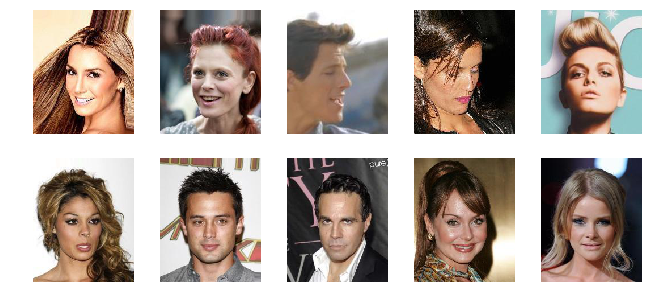

In [4]:
data = MyDataGenerator(1000)
gen = data(16)
aa, _ = next(gen)
print(aa[0].shape, aa[0].min(), aa[0].max())
figsize(11, 5)
for i in range(10):
    plot.subplot(2, 5, i+1)
    plot.imshow(aa[i])
    plot.axis('off')

In [5]:
N = 100000
batch_size = 100
stride = 2

data = MyDataGenerator(N, stride=stride, color=False, flatten=True)

original_image_shape = data.original_shape
train_steps = data.get_steps_per_epoch(batch_size)
valid_steps = data.get_steps_per_epoch(batch_size, True)

train_gen = data(batch_size)
valid_gen = data(batch_size, True)

flatten_dim = np.prod(original_image_shape[:-1]) // (stride * stride)
print(flatten_dim, train_steps, valid_steps)


9701 750 250


In [6]:
# http://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
    
latent_dim = 64
intermediate_dim = 512

# Q(z|X) -- encoder
inputs     = Input(shape=(flatten_dim,))
enc_hidden = Dense(intermediate_dim, activation='relu')(inputs)
enc_bn     = BatchNormalization()(enc_hidden)
enc_mean   = Dense(latent_dim, activation='linear')(enc_bn)
enc_logvar = Dense(latent_dim, activation='linear')(enc_bn)

def sample_z(args, batch_size=batch_size, latent_dim=latent_dim):
    enc_mean, enc_logvar = args
    # para usar a linha seguinte é preciso especificar batch_shape em Input
    # eps = K.random_normal(shape=enc_mean.shape, mean=0.0, stddev=1.0)
    eps = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=1.0)
    return enc_mean + K.exp(enc_logvar / 2) * eps

# Sample z ~ Q(z|X)
enc_sampled = Lambda(sample_z)([enc_mean, enc_logvar])

# P(X|z) -- decoder
decoder_hidden_layer = Dense(intermediate_dim, activation='relu')
decoder_output_layer = Dense(flatten_dim, activation='sigmoid')

dec_hidden = decoder_hidden_layer(enc_sampled)
dec_bn     = BatchNormalization()(dec_hidden)
outputs    = decoder_output_layer(dec_bn)

# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)
vae.summary()

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, [enc_mean, enc_logvar])

# Generator model, generate new data given latent variable z
dec_in  = Input(shape=(latent_dim,))
dec_h   = decoder_hidden_layer(dec_in)
dec_out = decoder_output_layer(dec_h)
decoder = Model(dec_in, dec_out)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 9701)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 512)           4967424     input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 512)           2048        dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 64)            32832       batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [7]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    
    # Kullback–Leibler divergence
    # calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(enc_logvar) + K.square(enc_mean) - 1. - enc_logvar, axis=1)

    return recon + kl

vae.compile(optimizer='adam', loss=vae_loss)


In [13]:
from keras.callbacks import Callback
class MyCb(Callback):
    def __init__(self, n):
        self.n = n
        self.t0 = time.time()
    
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.n == 0:
            print('{:5d}: {:.5f}  {:.5f}  [{:.2f}s]'.format(epoch, logs['loss'], logs['val_loss'], time.time() - self.t0))
            self.t0 = time.time()


trainIt = 1
model_weights_fn = '../../models/vae_celeba_bn_100k.weights'

if os.path.isfile(model_weights_fn):
    vae.load_weights(model_weights_fn)

if trainIt:
    nb_epochs = 50

    log = MyCb(1)
    ckp = ModelCheckpoint(model_weights_fn, monitor='val_loss', verbose=0,
                          save_weights_only=True, save_best_only=True, mode='min')

    try:
        vae.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=nb_epochs, verbose=0,
                          validation_data=valid_gen, validation_steps=valid_steps, callbacks=[log, ckp])
    except KeyboardInterrupt:
        print("Interrupted!")

    0: 5200.94237  5211.48338  [169.72s]
    1: 5190.96934  5199.44636  [166.33s]
    2: 5184.63563  5212.20196  [165.78s]
    3: 5179.96186  5195.26604  [167.00s]
    4: 5176.84652  5187.77598  [157.12s]
    5: 5173.73809  5184.38489  [157.42s]
    6: 5171.28645  5183.99028  [156.42s]
    7: 5169.36105  5180.50837  [156.87s]
    8: 5167.51182  5174.78688  [156.45s]
    9: 5166.07106  5173.57126  [156.43s]
   10: 5164.78567  5170.80316  [156.84s]
   11: 5163.64320  5167.15635  [156.50s]
   12: 5162.64349  5165.56799  [157.39s]
   13: 5161.68211  5163.29679  [157.58s]
   14: 5160.69024  5164.17686  [156.51s]
   15: 5159.74444  5162.81512  [156.71s]
   16: 5158.91644  5160.23070  [156.88s]
   17: 5158.13017  5159.58104  [156.38s]
   18: 5157.67090  5159.32005  [157.04s]
   19: 5156.95274  5158.04995  [156.22s]
   20: 5156.44060  5156.20432  [155.54s]
   21: 5155.89838  5155.02710  [155.73s]
   22: 5155.40983  5155.67497  [155.31s]
   23: 5154.88803  5154.44858  [156.04s]
   24: 5154.5940

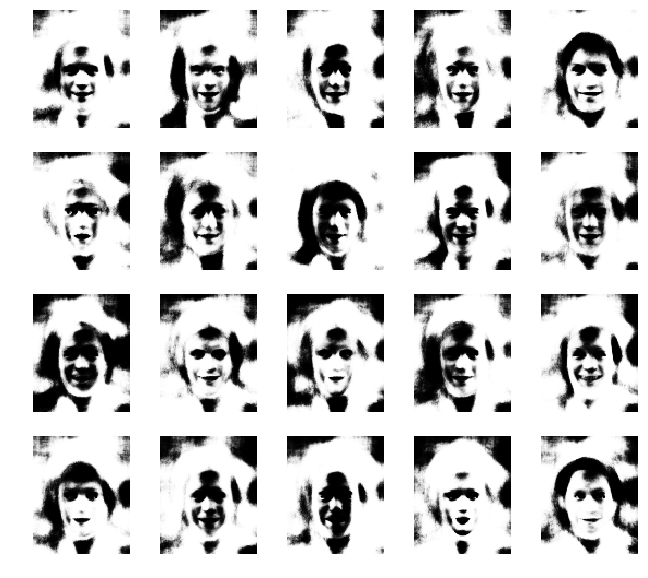

In [21]:
bs = 20
samples = nr.normal(0.0, 1.0, size=(bs, latent_dim))
aa = decoder.predict(samples, batch_size=bs)
bb = aa.reshape(bs, 109, 89)

figsize(11, 10)
for i, img in enumerate(bb):
    plot.subplot(4, 5, i+1)
    plot.imshow(img, cmap=plot.cm.gray)
    plot.axis('off')    

(109, 89) (100, 9701) (100, 109, 89)


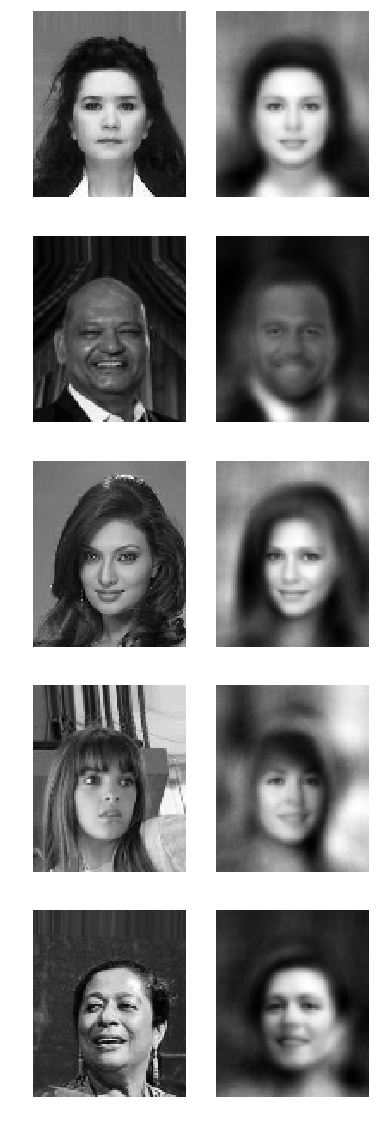

In [15]:
m = nr.randint(N)
img1 = data.get_images(m, batch_size)
flat = img1.reshape(batch_size, -1)
img2 = vae.predict(flat, batch_size=batch_size).reshape(img1.shape)
print(img.shape, flat.shape, img2.shape)

figsize(6, 20)
for i in range(5):
    plot.subplot(5, 2, 2*i+1)
    plot.imshow(img1[i], cmap=plot.cm.gray)
    plot.axis('off')
    
    plot.subplot(5, 2, 2*i+2)
    plot.imshow(img2[i], cmap=plot.cm.gray)
    plot.axis('off')    

[[ 0.447 -1.52   0.803  0.105 -0.73  -1.34  -2.22  -0.791 -3.008 -0.054  0.808 -0.702  0.374 -0.864  0.861  3.726  0.009
   1.369  1.102 -1.057  1.172 -0.73   1.545 -1.159  1.173  0.903  0.62  -0.587  0.92  -0.428  0.603  1.307 -1.855 -0.506
  -0.619 -1.463  1.277  0.726 -0.088 -1.578 -0.213 -0.1    0.875 -1.088 -0.365  0.635  0.053 -1.739  0.149  1.617  1.194
  -0.844  1.664  0.318  0.432  0.336  1.     0.299  1.444 -1.157 -0.688 -0.64  -0.55   1.426]]
0.00261437908497 0.985620915033 9.76359e-07 1.0


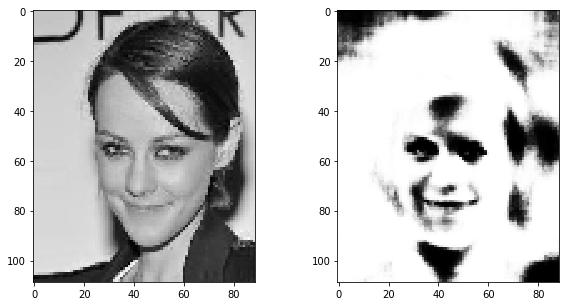

In [25]:
m = nr.randint(N)
img = data.get_datum(m).reshape(1, -1)
code_mean, code_logvar = encoder.predict(img, batch_size=1)

sampled = nr.normal(code_mean, np.exp(code_logvar/2.0))
print(code_mean)

img1 = data.get_image(m)
img2 = decoder.predict(sampled).reshape(img1.shape)
print(img1.min(), img1.max(), img2.min(), img2.max())
figsize(10, 5)
plot.subplot(1, 2, 1)
plot.imshow(img1, cmap='gray')
plot.subplot(1, 2, 2)
plot.imshow(img2, cmap='gray')

dict_keys(['loss', 'val_loss'])

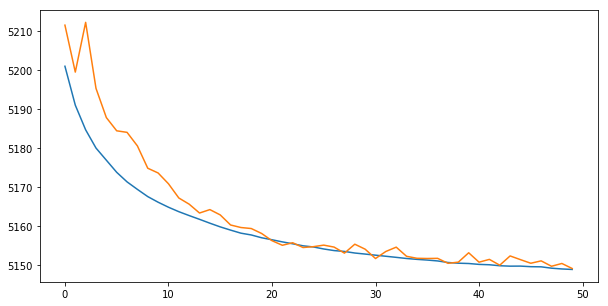

In [17]:
plot.plot(vae.history.history['loss'])
plot.plot(vae.history.history['val_loss'])
vae.history.history.keys()